In [12]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pylab as plt

import stretchablecorr as sc

In [13]:
cube, image_names = sc.load_image_sequence('./images/HS2_01/')

Load images from ./images/HS2_01/...
Image sequence:
 24 frames , 1392*1024 pixels , memory size: 261 Mo
 images: 00p000001.TIF, 00p100012.TIF, 00p200023.TIF , ... ,  60p000278.TIF


grid size: 12x9
 i.e. 108 points


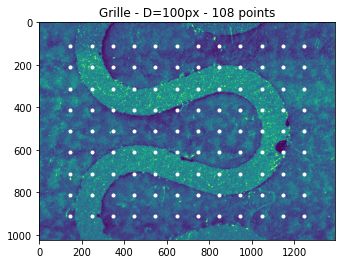

In [59]:
# ==================
#  Define the grid
# ==================

grid_spacing = 100 
grid_margin = 105
# ----
grid = sc.build_grid(cube.shape[1:], margin=grid_margin, spacing=grid_spacing)
points = np.stack( (grid[0].flatten(), grid[1].flatten()), axis=-1 )

# Graph the grid
plt.figure();
plt.title(f'Grille - D={grid_spacing}px - {points.shape[0]} points');
sc.plot_grid_points(grid, background=cube[0],
                    color='white', markersize=3)

In [69]:
def _triangulate_xy(I, J, K, xy, params):
    
    u_ij, err = sc.get_shifts(I, J, *xy, **params)

    xy_j = xy + u_ij
    u_jk, err = sc.get_shifts(J, K, *xy_j, **params)
    x_ijk = xy_j + u_jk

    u_ik, err = sc.get_shifts(I, K, *xy, **params)
    x_ik = xy + u_ik

    d = np.sqrt(np.sum((x_ik - x_ijk)**2))
    return d, max(np.sqrt(np.sum(u_ij**2)),
                  np.sqrt(np.sum(u_jk**2)),
                  np.sqrt(np.sum(u_ik**2)))


def triangulate(I, J, K, points, params):
    
    errors = []
    distances = []
    for xy in points:
        try:
            err, d = _triangulate_xy(I, J, K, xy, params)
            errors.append(err)
            distances.append(d)
        except ValueError:
            pass
        
    return np.array(errors), np.array(distances)

def construct_key(p):
    name = f"{p['window_half_size']}px"
    if p['coarse_search']:
        name += '_coarse'
    if p['phase']:
        name += '_phase'
    else:
        name += 'CC'
    name += '_' + p['method']
    return name

In [102]:
results = {}
ijk = 0, 2, 4
ijk = 17, 18, 19
IJK = [cube[idx] for idx in ijk]

coarse_search = True
params = {'window_half_size': 40,
          'coarse_search':coarse_search,
          'phase': False,
          'method':'opti' }
results[construct_key(params)] = triangulate(*IJK, points, params)

params = {'window_half_size': 15,
          'coarse_search':coarse_search,
          'phase': False,
          'method':'opti' }
results[construct_key(params)] = triangulate(*IJK, points, params)


params = {'window_half_size': 20,
          'coarse_search':coarse_search,
          'phase': True,
          'method':'opti' }
results[construct_key(params)] = triangulate(*IJK, points, params)

params = {'window_half_size': 40,
          'coarse_search':coarse_search,
          'phase': True,
          'method':'opti' }
results[construct_key(params)] = triangulate(*IJK, points, params)

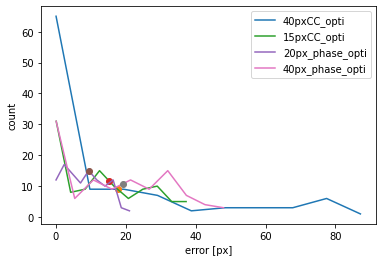

In [90]:
for key, (errors, distances) in results.items():
    d_mean = np.mean(errors)
    n, bins = np.histogram(errors);
    plt.plot(bins[:-1], n, label=key)
    
    plt.plot(d_mean, np.interp(d_mean, bins[:-1], n), 'o')

plt.legend(); plt.xlabel('error [px]')
plt.ylabel('count');

In [103]:
sorted_results = sorted(list(results.items()), key=lambda x:np.mean(x[1][0]))

In [101]:
print('\n'.join([f'{k[0]:<20} {np.mean(k[1][0]): 7.2f} {np.mean(k[1][1])}'
       for k in sorted_results]))

20px_phase_opti         9.42 8.576231572483684
15pxCC_opti            15.23 13.751614655654786
40pxCC_opti            17.64 26.28195920947019
40px_phase_opti        19.21 18.241132457574455


In [104]:
print('\n'.join([f'{k[0]:<20} {np.mean(k[1][0]): 7.2f} {np.mean(k[1][1])}'
       for k in sorted_results]))

15px_coarseCC_opti     13.92 29.910678116130637
40px_coarseCC_opti     14.69 32.93321053611752
40px_coarse_phase_opti   14.77 31.255842745998883
20px_coarse_phase_opti   16.15 30.535217185822052


In [88]:
print('\n'.join([f'{k[0]:<20} {np.mean(k[1][0])}'
       for k in sorted_results]))

40pxCC_opti          0.13291181977007294
40px_phase_opti      0.1499698289412096
15pxCC_opti          0.18231776868004598
20px_phase_opti      0.28273282830294405


In [68]:
plt.imshow(distances_grid);
plt.colorbar();

NameError: name 'distances_grid' is not defined

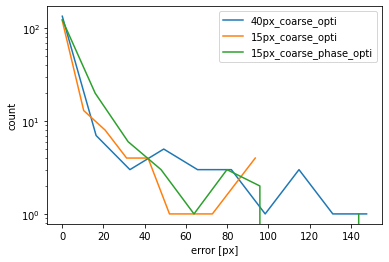

In [45]:
results = {}
ijk = 17, 18, 19
IJK = [cube[idx] for idx in ijk]

params = {'window_half_size': 40,
          'coarse_search':True,
          'phase': False,
          'method':'opti' }

results[construct_key(params)] = triangulate(*IJK, points, params)

params = {'window_half_size': 15,
          'coarse_search':True,
          'phase': False,
          'method':'opti' }

results[construct_key(params)] = triangulate(*IJK, points, params)

params = {'window_half_size': 15,
          'coarse_search':True,
          'phase': True,
          'method':'opti' }

results[construct_key(params)] = triangulate(*IJK, points, params)

for key, distances in results.items():
    n, bins = np.histogram(distances);
    plt.semilogy(bins[:-1], n, label=key)
    
plt.legend(); plt.xlabel('error [px]')
plt.ylabel('count');